# Flowers Classification

This is my first attempt to implement an image classifier model since I began to learn Deep Learning with PyTorch.
As the name suggests, this project model is going to classify the type of different flowers using Deep Learning with PyTorch.

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
# Installing prerequisites
!pip install jovian opendatasets --upgrade -q

# System level 
import os
import random
import statistics
import math
import shutil

import jovian
import opendatasets
import PIL
import IPython.display
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import numpy as np

# Shortcuts
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

%matplotlib inline

project_name = 'Flower-Classification-Project'

The dataset is taken from Kaggle.

In [4]:
opendatasets.download('https://www.kaggle.com/alxmamaev/flowers-recognition')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: priyanshukr
Your Kaggle Key: ··········


  1%|          | 5.00M/450M [00:00<00:14, 31.8MB/s]

100%|██████████| 450M/450M [00:07<00:00, 59.0MB/s]


## Exploratory Analysis

The dataset contains large number of images of various flowers. Images are grouped in subfolders. Each class of image is in a separate folder.

In [5]:
root = os.path.join(os.getcwd(), 'flowers-recognition')

classes = [
  'daisy',
  'dandelion',
  'rose',
  'sunflower',
  'tulip'
]

Let's see any image from each class (or folder).

Folder:	daisy
File:	34522174462_b7cbee3ecb_n.jpg


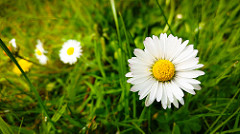


Folder:	dandelion
File:	19586799286_beb9d684b5.jpg


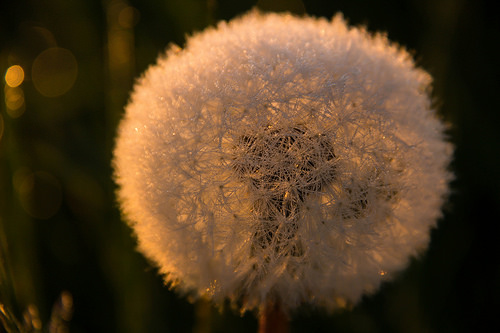


Folder:	rose
File:	1446097778_97149b8362.jpg


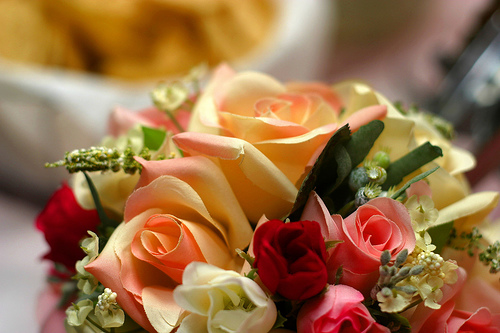


Folder:	sunflower
File:	20972862281_5367f4af88.jpg


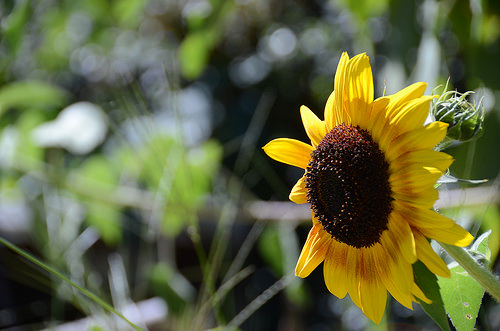


Folder:	tulip
File:	13903946578_187f904c9a_n.jpg


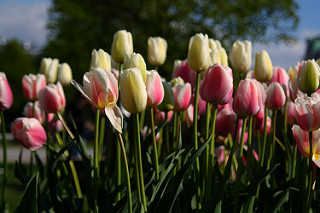

In [6]:
for folder in classes:
  file = os.listdir(os.path.join(root, 'flowers', folder))[0]
  print(f'Folder:\t{folder}\nFile:\t{file}')
  display(IPython.display.Image(os.path.join(root, 'flowers', folder, file)))
  print()

It is clear from these images that these are of different proportions and sizes. Also, quality of images is not very good f.

## Preparation of Data

Let's figure out which image dimension is most common ammong dataset, while splitting initial data to two categories: `training` and `validation`. Will be splitting according to `90/10` ratio.

`training` and `validation` datasets will be moved to separate folders for easier usage by `ImageFolder` class.

There won't be any testing dataset, since that is not a competition.

`90/10` is taken as initial dataset is not that big, so increasing validation would mean stealing from testing which would lead to poor results in this particular case.

In [7]:
widths = []
heights = []

count = {
  'landscape': 0,
  'portrait': 0,
  'square': 0,
  'train': 0,
  'valid': 0
}

for slug in ['train', 'valid']:
  folder = os.path.join(root, slug)
  shutil.rmtree(folder, ignore_errors=True)
  os.mkdir(folder)

def update_stats(name):
  global count

  image = PIL.Image.open(name)
  width, height = image.size
  widths.append(width)
  heights.append(height)
  
  if width > height:
    count['landscape'] += 1
  elif height > width:
    count['portrait'] += 1
  else:
    count['square'] += 1

for x in classes:
  index_train = 0
  index_test = 0
  
  for slug in ['train', 'valid']:
    folder = os.path.join(root, slug, x)
    shutil.rmtree(folder, ignore_errors=True)
    os.mkdir(folder)

  images = os.listdir(os.path.join(root, 'flowers', x))
  images = list(filter(lambda x: x.endswith('jpg'), images))
  random.shuffle(images)
  border = int(len(images) * 0.9)
  
  train = images[:border]
  valid = images[border:]

  count['train'] += len(train)
  count['valid'] += len(valid)
  
  for y in images:
    name = os.path.join(root, 'flowers', x, y)
    update_stats(name)

    destination = None
    file = None

    if y in train:
      destination = 'train'
      file = f'{index_train:04d}.jpg'
      index_train += 1
    else:
      destination = 'valid'
      file = f'{index_test:04d}.jpg'
      index_test += 1

    shutil.copyfile(name, os.path.join(root, destination, x, file))


print(f'Most common image width\t: {math.floor(statistics.mean(widths))}')
print(f'Most common image height\t: {math.floor(statistics.mean(heights))}')
print()
print(f'Landscape images\t: {count["landscape"]}')
print(f'Portrait images\t\t: {count["portrait"]}')
print(f'Square images\t\t: {count["square"]}')
print()
print(f'Training images\t\t: {count["train"]}')
print(f'Validation images\t: {count["valid"]}')

Most common image width	: 338
Most common image height	: 252

Landscape images	: 3526
Portrait images		: 578
Square images		: 219

Training images		: 3888
Validation images	: 435


Most common is landscape orientation and if we would take `256x256` as size of the image to classify that would mean minimum resizing and still some space for data augumentation.

Let's create deterministic `CentralCrop` function that could be used on validation dataset, as opposite to `RandomCrop` that would be called on testing dataset.

In [8]:
class CentralCrop(object):
  def __init__(self, size):
    self.dimensions = (size, size)

  def __call__(self, pic):
    """
    Args:
        pic (PIL Image or numpy.ndarray): Image to be cropped.
    Returns:
        Tensor: Cropped image.
    """
    width, height = pic.size
    
    offset = (0, 0)

    if width > height:
      offset = (math.floor((height - width)/2), 0)
      width = height
    elif height > width:
      offset = (0, math.floor((width - height)/2))
      height = width
    
    temp = PIL.Image.new('RGB', (width, height))
    temp.paste(pic, offset)
    pic = temp.resize(self.dimensions, PIL.Image.NEAREST)

    return pic

  def __repr__(self):
    return self.__class__.__name__ + '()'

We will be performing following data transformations:

- Resize to `256px`, since images mostly are not square, they would still have some ratio to crop;
- Cropping random `256x256` square out of the resized image;
- Random horizontal flip;

Data normalization was not performed, since color information is important to flower detection, so if its color distribution would changed, it might be challenging to figure out what kind of flower is in the picture.


In [9]:
# Creating transformers for data augumentation
transformer = {
  'train': tt.Compose([
    tt.Resize(256),
    tt.RandomCrop(256),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
  ]),
  'valid': tt.Compose([
    tt.Resize(256),
    CentralCrop(256),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
  ]) 
}

# Creating instance of the dataset
data = {
  'train': ImageFolder(os.path.join(root, 'train'), transformer['train']),
  'valid': ImageFolder(os.path.join(root, 'valid'), transformer['valid'])
}

Let's check how our resizing / cropping worked on images, taking as example one of most unfortunate cases, when image needs to be upscaled as well as modifying respect ratio.

So far, it is possible to recover needed information from the input data visually.

Original image (320, 240):


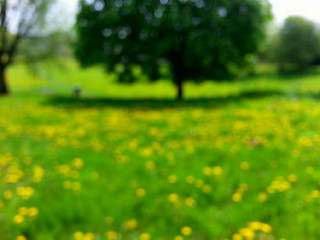


Transformed images (256, 256):


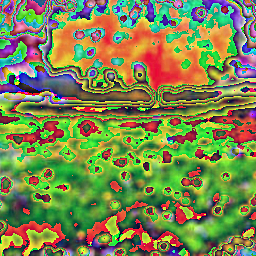

In [10]:
image = (ImageFolder(os.path.join(root, 'train')))[765][0]
print(f'Original image {image.size}:')
display(image)
print()

image = tt.ToPILImage()(data['train'][765][0])
print(f'Transformed images {image.size}:')
display(image)

Let's get some stats from our dataset. We indeed loosing some visual information, but it is a better option as per data.

In [11]:
stats = {}

for _, label in data['train']:
  if label not in stats:
    stats[label] = 1
  else:
    stats[label] = stats[label] + 1
  
print(f'Number of data classes\t: {len(stats.keys())}')
print()

for key, value in stats.items():
  print(f'• {data["train"].classes[key].ljust(22)}: {value}')

Number of data classes	: 5

• daisy                 : 692
• dandelion             : 946
• rose                  : 705
• sunflower             : 660
• tulip                 : 885


## Preparing data for training

Since training will be done on GPU, we need to move data to GPU manually. For this purpose, we will create a wrapper for `DataLoader` as well as helper functions that will manage data transfer between the devices:

In [12]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device = None):
  """Move tensor(s) to chosen device"""
  if not device:
    device = get_default_device()
  
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  else:
    return data.to(device, non_blocking=True)

class SmartLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, data, batch_size):
    self.loader = DataLoader(
      data,
      batch_size,
      num_workers=4,
      shuffle=True,
      pin_memory=True)
    self.device = get_default_device()
        
  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for batch in self.loader: 
      yield to_device(batch, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.loader)

## Defining the model

Let's define a base class that prove to be working smoothly with other image recognition tasks.

In [13]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch 
    out = self(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss
  
  @torch.no_grad()
  def validation_step(self, batch):
    images, labels = batch 
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}
      
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  
  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Defining convolutional block in the way that we can re-use it in the model:

In [14]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
    nn.BatchNorm2d(out_channels), 
    nn.ReLU(inplace=True)]
  if pool:
    layers.append(nn.MaxPool2d(2))
  
  return nn.Sequential(*layers)

The model represents standard `ResNet9` architechture which is able to recognize images quite easily.

In [15]:
class FlowersModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()

    self.conv1 = conv_block(3, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

    self.classifier = nn.Sequential(
      nn.MaxPool2d(8), 
      nn.Flatten(), 
      nn.Dropout(0.2),
      nn.Linear(8192, 5)
    )
      
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out

## Training the Model

Training loop is pretty standard and used without changes several times already.

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
  torch.cuda.empty_cache()
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []
  
  # Set up cutom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  # Set up one-cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                              steps_per_epoch=len(train_loader))
  
  for epoch in range(epochs):
    # Training Phase 
    model.train()
    train_losses = []
    lrs = []
    
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      
      # Gradient clipping
      if grad_clip: 
          nn.utils.clip_grad_value_(model.parameters(), grad_clip)
      
      optimizer.step()
      optimizer.zero_grad()
      
      # Record & update learning rate
      lrs.append(get_lr(optimizer))
      sched.step()
    
    # Validation phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
      
  return history

Let's create model instance, as well as data loaders that were prepared in previously.

In [ ]:
# Creating instance of the model
model = to_device(FlowersModel());

# Setting batch size
batch_size=32

# Creating data loaders
loader = {
  'train': SmartLoader(data['train'], batch_size),
  'valid': SmartLoader(data['valid'], batch_size*2)
}

In [ ]:
images, _ = next(iter(loader['train']))
grid = make_grid(images, nrow=8)
display(tt.ToPILImage()(grid))

Let's check initial accuracy of not yet trained model. Intuition is that value should be around 20% as we have 5 unique data classes i.e. `100/5`:

In [ ]:
history = [evaluate(model, loader["valid"])]

print(f'{round(history[0]["val_acc"], 4) * 100}%')

In [ ]:
%%time
epochs = 30
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

history += fit_one_cycle(epochs, max_lr, model, loader['train'], loader['valid'], 
                        grad_clip=grad_clip, 
                        weight_decay=weight_decay, 
                        opt_func=opt_func)

Epoch [0], train_loss: 1.6787, val_loss: 1.2244, val_acc: 0.5561
Epoch [1], train_loss: 1.5967, val_loss: 1.9632, val_acc: 0.5427
Epoch [2], train_loss: 2.0066, val_loss: 1.8551, val_acc: 0.5522
Epoch [3], train_loss: 2.0502, val_loss: 1.6893, val_acc: 0.5595
Epoch [4], train_loss: 1.6441, val_loss: 2.9371, val_acc: 0.3791
Epoch [5], train_loss: 1.3715, val_loss: 1.2242, val_acc: 0.5644
Epoch [6], train_loss: 1.0493, val_loss: 0.7683, val_acc: 0.7107
Epoch [7], train_loss: 0.9312, val_loss: 0.8568, val_acc: 0.6461
Epoch [8], train_loss: 0.9045, val_loss: 0.8957, val_acc: 0.6833
Epoch [9], train_loss: 0.8478, val_loss: 0.6976, val_acc: 0.7437
Epoch [10], train_loss: 0.8145, val_loss: 0.6498, val_acc: 0.7538
Epoch [11], train_loss: 0.7833, val_loss: 0.6802, val_acc: 0.7543
Epoch [12], train_loss: 0.7963, val_loss: 0.6941, val_acc: 0.7314
Epoch [13], train_loss: 0.7365, val_loss: 0.6789, val_acc: 0.7526
Epoch [14], train_loss: 0.7046, val_loss: 0.5959, val_acc: 0.7734
Epoch [15], train_lo

In [ ]:
torch.save(model.state_dict(), 'flowers-resnet9.pth')

## Analysis of results

Let's plot how accuracy changed during model training.

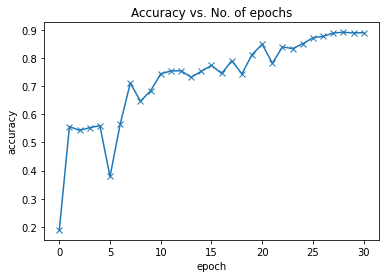

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

We also need to check how loss on training dataset and on validation dataset behave.

If everything is worked fine, model should not overfit to training data, meaning `loss` for validation should go to the same direction as `loss` for training set.


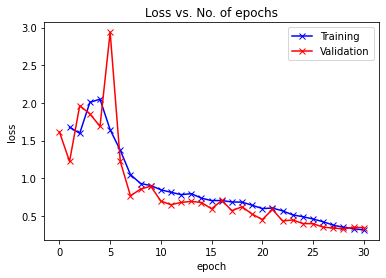

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

Loss decrease on validation dataset definitely slowed down later in the history, but still early to say that the model is overfitting.

Let's check how learning rate was changing during the learning process:

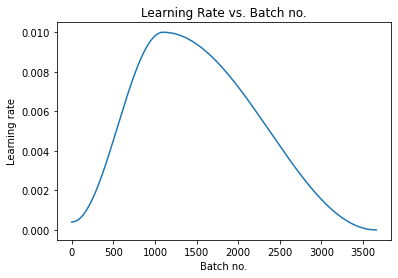

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

Let's also check our prediction results – does the model performs well on the validation set. We will take three random images:


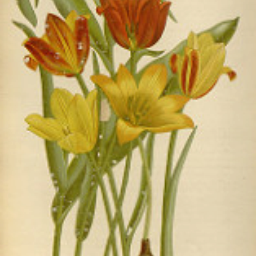

Label: tulip , Predicted: tulip


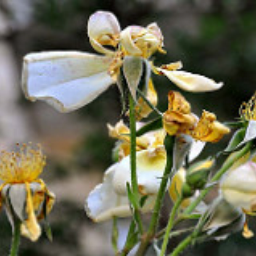

Label: rose , Predicted: daisy


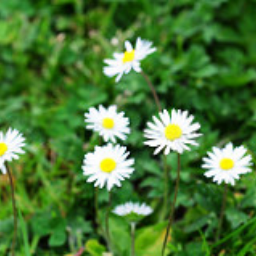

Label: daisy , Predicted: daisy


In [ ]:
def predict_image(img, model):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0))
  # Get predictions from model
  yb = model(xb)
  # Pick index with highest probability
  _, preds  = torch.max(yb, dim=1)
  # Retrieve the class label
  return classes[preds[0].item()]

def denormalize(img):
  return tt.Normalize(
    [-0.485/0.229, -0.456/0.224, -0.406/0.225],
    [1.0/0.229, 1.0/0.224, 1.0/0.225]
  )(img)

for i in range(3):
  index = random.randint(0, len(data['valid']))
  img, label = data['valid'][index]
  display(tt.ToPILImage()(denormalize(img)))
  print('Label:', classes[label], ', Predicted:', predict_image(img, model))

Let's check final accuracy of our model after training:


In [ ]:
print(f'{round(evaluate(model, loader["valid"])["val_acc"], 2) * 100}%')

88.0%


## Conclusion

After training, model's accuracy raised from 17.03% to 82.0%, after training about an hour. Although results could be better we need to remember that source data set was relatively low quality and despite all that the model is not overfitting.


In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

jovian.commit(project=project_name, environment=None, outputs=['flowers-resnet9.pth'])